<hr>
# Obstacle-Detection-and-Path-Planning

Path planning is a technique used for find the shortest path between a source and destination.
Path planning ensures that navigation is done in least time and in most optimized way, saving energy and providing a optimized way of the doing task.

Here's [Siraj Raval's](https://www.youtube.com/channel/UCWN3xxRkmTPmbKwht9FuE5A) explanation of this project. He is an awesome YouTube star with his own channel with lots of amazing Machine Learning tutorial videos. He conducted a live Youtube session explaining each line of the code. You can watch the video if you want to but I really recommend to follow his channel. It's one of the best for tutorials regarding Machine Learning and AI.

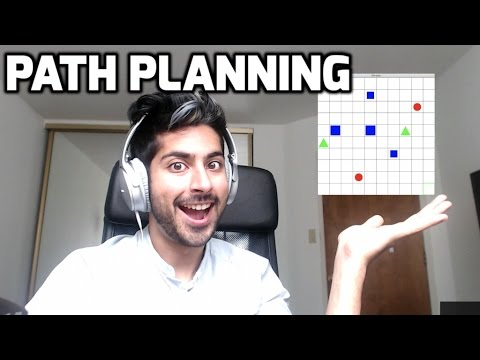

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('2cQK_brSVvo')

<hr>

## Given:

A set of test images, each containing

1. 10x10 grid, making 100 squares
2. Obstacles marked as black square
3. Objects defined by three features, viz. Shape, Size and Color 

<img src="https://raw.githubusercontent.com/Aniruddha-Tapas/Obstacle-Detection-and-Path-Planning/master/test_images/test_image4.jpg" width="400" height= "400" />

The squares are identified by the coordinate (x,y) where x is the column and y is the row to which the square belongs. Each square
can be empty or have an Obstacle or have an Object.

## Dependencies

[Use pip to install.](https://pypi.python.org/pypi/pip)

1.  Install OpenCV for Python

	[`For Windows`](http://docs.opencv.org/3.1.0/d5/de5/tutorial_py_setup_in_windows.html)

	[`For Ubuntu`](http://www.pyimagesearch.com/2015/06/22/install-opencv-3-0-and-python-2-7-on-ubuntu/)

2. 
Install skimage (or scikit-image)

	Open command prompt and type in:
	```pip install scikit-image```

3. 
Install numpy 

	Open command prompt and type in:
	```pip install numpy```

Let's dive into the code:

## `astarsearch.py`

`astarsearch.py` contains the implementation of A\* search algorithm that we would use as our search strategy for finding the obstacles and similar objects.  


In [1]:
#A* Search algorithm implementation to find the minimum path between 2 points

def astar(m,startp,endp):
    w,h = 10,10		# 10x10(blocks) is the dimension of the input images
    sx,sy = startp 	#Start Point
    ex,ey = endp 	#End Point
    #[parent node, x, y, g, f]
    node = [None,sx,sy,0,abs(ex-sx)+abs(ey-sy)] 
    closeList = [node]
    createdList = {}
    createdList[sy*w+sx] = node
    k=0
    while(closeList):
        node = closeList.pop(0)
        x = node[1]
        y = node[2]
        l = node[3]+1
        k+=1
        #find neighbours 
        if k!=0:
            neighbours = ((x,y+1),(x,y-1),(x+1,y),(x-1,y))
        else:
            neighbours = ((x+1,y),(x-1,y),(x,y+1),(x,y-1))
        for nx,ny in neighbours:
            if nx==ex and ny==ey:
                path = [(ex,ey)]
                while node:
                    path.append((node[1],node[2]))
                    node = node[0]
                return list(reversed(path))            
            if 0<=nx<w and 0<=ny<h and m[ny][nx]==0:
                if ny*w+nx not in createdList:
                    nn = (node,nx,ny,l,l+abs(nx-ex)+abs(ny-ey))
                    createdList[ny*w+nx] = nn
                    #adding to closelist ,using binary heap
                    nni = len(closeList)
                    closeList.append(nn)
                    while nni:
                        i = (nni-1)>>1
                        if closeList[i][4]>nn[4]:
                            closeList[i],closeList[nni] = nn,closeList[i]
                            nni = i
                        else:
                            break
    return []

## `traversal.py`

`traversal.py` contains the script to traverse through the image to find objects/min path. 

In [2]:
#Traversing through the image to perform image processing

def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in xrange(0, image.shape[0], stepSize):
		for x in xrange(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


## `process_image.py`

The `process_image.py` contains the major code.
Check that script to see the main functionality.
Follow the comments to undertand the code better.


In [ ]:
import cv2
import numpy as np
import time
from skimage.measure import compare_ssim as ssim #to compare 2 images

import astarsearch
import traversal


def main(image_filename):
	'''
	Returns:
	1 - List of tuples which is the coordinates for occupied grid. 
	2 - Dictionary with information of path. 
	'''

	occupied_grids = []		# List to store coordinates of occupied grid 
	planned_path = {}		# Dictionary to store information regarding path planning  	
	
	# load the image and define the window width and height
	image = cv2.imread(image_filename)
	(winW, winH) = (60, 60)		# Size of individual cropped images 

	obstacles = []			# List to store obstacles (black tiles)  
	index = [1,1]
	blank_image = np.zeros((60,60,3), np.uint8)
	list_images = [[blank_image for i in xrange(10)] for i in xrange(10)] 	#array of list of images 
	maze = [[0 for i in xrange(10)] for i in xrange(10)] 			#matrix to represent the grids of individual cropped images

	for (x, y, window) in traversal.sliding_window(image, stepSize=60, windowSize=(winW, winH)):
		# if the window does not meet our desired window size, ignore it
		if window.shape[0] != winH or window.shape[1] != winW:
			continue

	#	print index
		clone = image.copy()
		cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
		crop_img = image[x:x + winW, y:y + winH] 				#crop the image
		list_images[index[0]-1][index[1]-1] = crop_img.copy()			#Add it to the array of images

		average_color_per_row = np.average(crop_img, axis=0)
		average_color = np.average(average_color_per_row, axis=0)
		average_color = np.uint8(average_color)					#Average color of the grids
	#	print (average_color)

		if (any(i <= 240 for i in average_color)):				#Check if grids are colored
			maze[index[1]-1][index[0]-1] = 1				#ie not majorly white
			occupied_grids.append(tuple(index))				#These grids are termed as occupied_grids 
	#		print ("occupied")						#and set the corresponding integer in the maze as 1

		if (any(i <= 20 for i in average_color)):				#Check if grids are black in color
	#		print ("black obstacles")
			obstacles.append(tuple(index))					#add to obstacles list

	
		cv2.imshow("Window", clone)
		cv2.waitKey(1)
		time.sleep(0.025)
	
		#Iterate
		index[1] = index[1] + 1							
		if(index[1]>10):
			index[0] = index[0] + 1
			index[1] = 1


	"""
	##########
	#Uncomment this portion to print the occupied_grids (First Part Solution)
	print "Occupied Grids : "
	print occupied_grids
	"""


	"""
	#Printing other info
	print "Total no of Occupied Grids : "
	print len(occupied_grids)
	print "Obstacles : "
	print obstacles
	print "Map list: "
	print maze
	print "Map : "
	for x in xrange(10):
		for y in xrange(10):
			if(maze[x][y] == -1):
				print str(maze[x][y]),			
			else:
				print " " + str(maze[x][y]),
		print ""
	"""

#First part done
##############################################################################

	list_colored_grids = [n for n in occupied_grids if n not in obstacles]	#Grids with objects (not black obstacles)
	"""
	print "Colored Occupied Grids : "
	print list_colored_grids
	print "Total no of Colored Occupied Grids : " + str(len(list_colored_grids))
	"""

	#Compare each image in the list of objects with every other image in the same list
	#Most similar images return a ssim score of > 0.9
	#Find the min path from the startimage to this similar image u=by calling astar function

	for startimage in list_colored_grids:
		key_startimage = startimage
		img1 = list_images[startimage[0]-1][startimage[1]-1]
		for grid in [n for n in list_colored_grids  if n != startimage]:
			img = 	list_images[grid[0]-1][grid[1]-1]
	#		print "for {0} , other images are {1}".format(key_startimage, grid)
			image = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
			image2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
			s = ssim(image, image2)
			if s > 0.9:
				result = astarsearch.astar(maze,(startimage[0]-1,startimage[1]-1),(grid[0]-1,grid[1]-1))
	#			print result
				list2=[]
				for t in result:
					x,y = t[0],t[1]
					list2.append(tuple((x+1,y+1)))			#Contains min path + startimage + endimage
					result = list(list2[1:-1]) 			#Result contains the minimum path required 

	#			print "similarity :" +  str(s)
				if not result:						#If no path is found;
					planned_path[startimage] = list(["NO PATH",[], 0])
				planned_path[startimage] = list([str(grid),result,len(result)+1])


	#print "Dictionary Keys pf planned_path:"
	#print planned_path.keys()

	for obj in list_colored_grids:
		if not(planned_path.has_key(obj)):					#If no matched object is found;
			planned_path[obj] = list(["NO MATCH",[],0])			


	"""
	##########
	#Uncomment this portion to print the planned_path (Second Part Solution)
	print "Planned path :"
	print planned_path
	"""

#Second part done
##############################################################################

	return occupied_grids, planned_path



if __name__ == '__main__':

    # change filename to check for other images
    image_filename = "test_images/test_image1.jpg"

    main(image_filename)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Basic Usage

Run `main.py` to check the results.
You can edit the test image from main.py to see different results.

### `main.py`

In [ ]:
import process_image
occupied_grids, planned_path = process_image.main("test_images/test_image3.jpg")
print "Occupied Grids : "
print occupied_grids
print "Planned Path :"
print planned_path

<hr>

### The program returns 2 major findings:

<img src="https://raw.githubusercontent.com/Aniruddha-Tapas/Obstacle-Detection-and-Path-Planning/master/screenshot.png" />


1. <b><u>The coordinates of occupied grid</u></b>:

	The code returns a python list having ‘n’ python tuples, where ‘n’ denotes number of occupied grid in test image. Grid is to be considered occupied if either grid has an Obstacle or an Object. Each tuple has two elements, first element is the x-coordinate of an Obstacle/Object and second element is the y-coordinate of the Obstacle.

2. <b><u>The minimum path</u></b>:

	For each object in the test images, a matching object which is nearest to it is found using `compare_ssim` function from `scikit-image`. Object is said to be nearest to another Object, if length of path traversed between two objects is smallest. Traversal is done by moving either horizontally or vertically. The length of the path is determined by the number of moves made during traversal. [A\* search](https://en.wikipedia.org/wiki/A*_search_algorithm) is used to find this shortest path.


The code return a python dictionary. Format for creating dictionary is as follows:
* Key for dictionary is a tuple - (x,y) coordinate of an Object
* first element of dictionary is a tuple - (x,y) coordinate of an object nearest to it
* second element is a list of tuples having (x,y) coordinate of all grids traversed i.e all route path
* third element of dictionary should be number of moves taken for traversal

<hr>